# Import packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

# Check GPU available

In [2]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


# Load MNIST datasets

In [3]:
# transform = transforms.Compose(
#     [transforms.ToTensor(), transforms.Normalize()]
# )
transform = transforms.Compose(
    [transforms.ToTensor()]
)

In [4]:
# loading MNIST train, test datasets
train = datasets.MNIST(root='MNIST', train=True, download=True, transform=transform)
test = datasets.MNIST(root='MNIST', train=False, download=True, transform=transform)

In [5]:
# datasets change to batch_size
# shuffle
# pin_memory
trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, pin_memory=True)
testset = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, pin_memory=True)

torch.Size([100, 1, 28, 28])


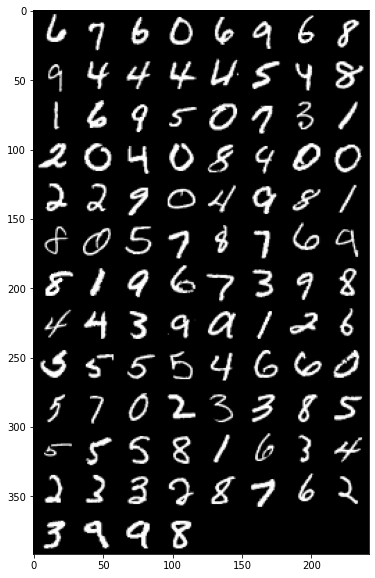

In [6]:
# show an image for example
images, labels = iter(trainset).next()
print(images.shape)

image = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 10)) 
plt.imshow(np.transpose(image, (1, 2, 0)))

# Create DNN model

In [7]:
class Net(nn.Module):
    def __init__(self): # __init__()定義Neural Network架構
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)  # input image size = 28 x 28
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)       # output size = 10 (0~9)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) 
        
        return F.log_softmax(x, dim=1) 
        
net = Net().to(device) # inital network
print(net)
print('Initialize DNN model finished.')

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)
Initialize DNN model finished.


# Create optimizer

In [8]:
# create Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training

In [9]:
# set network to training mode
net.train()

epochs = 2
for epoch in range(epochs):
    for data in trainset:
        image, label = data[0].to(device), data[1].to(device)
        
        # training process
        optimizer.zero_grad()
        predicted = net(image.view(-1, 28 * 28))
        loss = F.nll_loss(predicted, label)
        loss.backward()
        optimizer.step()
        
    print(f'epoch:{epoch}, loss:{loss}')

print('Training finished.')    

epoch:0, loss:0.14767876267433167
epoch:1, loss:0.18557393550872803
Training finished.


# Evaluation model

In [12]:
# set network to evaluation mode
net.eval()

# evaluation the training data
correct = 0
total = 0

with torch.no_grad():
    for data in trainset:
        image, label = data[0].to(device), data[1].to(device)
        output = net(image.view(-1, 28 * 28))
        correct  += (torch.argmax(output, dim=1) == label).sum().item()
        total += label.size(0)
        
print(f'Training data Accuracy: {correct}/{total} = {round(correct/total, 3)}')


# evaluation the testing data
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        image, label = data[0].to(device), data[1].to(device)
        output = net(image.view(-1, 28 * 28))
        correct  += (torch.argmax(output, dim=1) == label).sum().item()
        total += label.size(0)
        
print(f'Testing data Accuracy: {correct}/{total} = {round(correct/total, 3)}')

Training data Accuracy: 57115/60000 = 0.952
Testing data Accuracy: 9467/10000 = 0.947


# Create CNN model

In [13]:
class Net(nn.Module):
    def __init__(self): # __init__()定義Neural Network架構
        super(Net, self).__init__()
        # convolution 
        self.conv1 = nn.Conv2d(1, 64, 5)  # input channel=1, output channel=64, kernal size = 3*3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 5)
        # fully connected 
        self.fc1 = nn.Linear(32 * 4 * 4, 128) # 32 channel, 4 * 4 size(經過Convolution部分後剩4*4大小)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        
    def forward(self, x):
        # state size. 28 * 28(input image size = 28 * 28)
        x = self.pool(F.relu(self.conv1(x)))
        # state size. 12 * 12
        x = self.pool(F.relu(self.conv2(x)))
        # state size. 4 * 4
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim=1) 
        
net = Net().to(device) # inital network
print(net)
print('Initialize CNN model finished.')

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
)
Initialize CNN model finished.


# Create optimizer¶

In [18]:
# create Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training

In [19]:
# set network to training mode
net.train()

epochs = 2
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainset):
        image, label = data[0].to(device), data[1].to(device)
        
        # training process
        optimizer.zero_grad()
        predicted = net(image)
        loss = F.nll_loss(predicted, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99: 
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        
#     print(f'epoch:{epoch}, loss:{loss}')

print('Training finished.')    

[1,   100] loss: 1.993
[1,   200] loss: 0.451
[1,   300] loss: 0.235
[1,   400] loss: 0.178
[1,   500] loss: 0.148
[1,   600] loss: 0.120
[2,   100] loss: 0.103
[2,   200] loss: 0.097
[2,   300] loss: 0.088
[2,   400] loss: 0.084
[2,   500] loss: 0.075
[2,   600] loss: 0.067
Training finished.


# Evaluation model

In [20]:
# set network to evaluation mode
net.eval()

# evaluation the training data
correct = 0
total = 0

with torch.no_grad():
    for data in trainset:
        image, label = data[0].to(device), data[1].to(device)
        output = net(image)
        correct += (torch.argmax(output, dim=1) == label).sum().item()
        total += label.size(0)
        
print(f'Training data Accuracy: {correct}/{total} = {round(correct/total, 3)}')


# evaluation the testing data
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        image, label = data[0].to(device), data[1].to(device)
        output = net(image)
        correct += (torch.argmax(output, dim=1) == label).sum().item()
        total += label.size(0)
        
print(f'Testing data Accuracy: {correct}/{total} = {round(correct/total, 3)}')

Training data Accuracy: 58815/60000 = 0.98
Testing data Accuracy: 9794/10000 = 0.979
